# Machine Analysis

These notebooks look to analyse the time spent by each patient at the different machines. They use the geopandas package to capture the points in the polygons representing the different machines. They then look to capture the time spent in that machine.

## Package and Function Load In

In [ ]:
def lookup(date_pd_series, format=None):
    """
    This is an extremely fast approach to datetime parsing.
    For large data, the same dates are often repeated. Rather than
    re-parse these, we store all unique dates, parse them, and
    use a lookup to convert all dates.
    """
    dates = {date:pd.to_datetime(date, format=format) for date in date_pd_series.unique()}
    return date_pd_series.map(dates)

In [ ]:
!pip install geopandas
!pip install fiona
!pip install pyproj
!pip install rtree
!pip install pygeos

     |████████████████████████████████| 1.0 MB 4.3 MB/s 
     |████████████████████████████████| 6.3 MB 47.3 MB/s 
     |████████████████████████████████| 16.7 MB 293 kB/s 
     |████████████████████████████████| 1.0 MB 4.5 MB/s 
     |████████████████████████████████| 2.1 MB 4.2 MB/s 


## File Load In

In this section you must load in the appropriate patient journey file for analysis.

In [ ]:
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from shapely.geometry import Point, LineString, Polygon
from shapely.geometry import box
from shapely import wkt
import pandas as pd
import rtree
import pygeos
import geopandas as gpd
import numpy as np
import datetime as dt
import math
import seaborn as sns
import scipy.stats as sps
from scipy import stats
order_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
order_list_noweekend = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']


pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling

dftest = pd.read_csv('phase2_all_20220130.csv')

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Creating the Machine Polygon or MultiPolygon

The polygon coordinates are captured using the line_with_coordinates.html file. The polygon coordinates must be entered in the order of top left, bottom left, bottom right and then top right.

In [ ]:
AF_poly3 = Polygon([(10.0, 8.2), (10.0, 3.7), (12.0, 3.7), (12.0, 8.2)])

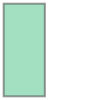

In [ ]:
AF_poly3

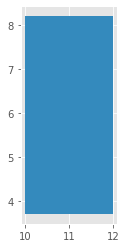

In [ ]:
 p = gpd.GeoSeries(AF_poly3)
 p.plot()
 plt.show()

## Data Cleaning and Formatting

In [ ]:
dftest = dftest.dropna()
dftest[['xlocation', 'ylocation']] = dftest['Location'].str.split(',', expand = True)

In [ ]:
dfG1221 = dftest.loc[dftest['Patient'] == 'G1221']

In [ ]:
column_list = list(dftest)
column_list

['Patient', 'Location', 'from', 'to', 'xlocation', 'ylocation']

## GeoPandas Dataframe Creation

This section creates a GeoPandas dataframe using the coordinates from the patient journey dataset.

The next section creates a geometry using the polygon or MultiPolygon shape that was created earlier.

In [ ]:
gdf = gpd.GeoDataFrame(
    dftest, geometry=gpd.points_from_xy(dftest.xlocation, dftest.ylocation))

In [ ]:
gdf['Location'] = gdf['Location'].astype(str)

In [ ]:
AF_poly3_gdf = gpd.GeoDataFrame(geometry  = gpd.GeoSeries(AF_poly3))

In [ ]:
AF_poly3_gdf

,geometry
0,"POLYGON ((10.00000 8.20000, 10.00000 3.70000, ..."


## Inner Join of the Two GeoPandas DataFrames

This section runs a spatial join of the two GeoDataframes it captures all of the points, in this example the patient journey points, that occur with in the polygon or MultiPolygon that was created earlier. This represents the time spent by the patient in the machine.

In [ ]:
AF_join = gpd.sjoin(gdf, AF_poly3_gdf, how = 'inner')
AF_join

,Patient,Location,from,to,xlocation,ylocation,geometry,index_right
17,G1221,"11.253,6.863",30/11/2021 10:13,30/11/2021 10:21,11.253,6.863,POINT (11.25300 6.86300),0
131,G1223,"11.25,4.502",30/11/2021 10:13,30/11/2021 10:22,11.25,4.502,POINT (11.25000 4.50200),0
394,G1223,"11.25,4.502",30/11/2021 11:50,30/11/2021 11:50,11.25,4.502,POINT (11.25000 4.50200),0
415,G1224,"11.25,4.502",30/11/2021 10:25,30/11/2021 10:26,11.25,4.502,POINT (11.25000 4.50200),0
416,G1224,"10.754,5.481",30/11/2021 10:26,30/11/2021 10:27,10.754,5.481,POINT (10.75400 5.48100),0
...,...,...,...,...,...,...,...,...
105162,R1306,"11.529,6.892",28/01/2022 10:31,28/01/2022 10:31,11.529,6.892,POINT (11.52900 6.89200),0
105353,R1306,"11.514,5.566",28/01/2022 11:08,28/01/2022 11:08,11.514,5.566,POINT (11.51400 5.56600),0
105659,R2000,"11.529,7.392",20/12/2021 10:53,20/12/2021 10:53,11.529,7.392,POINT (11.52900 7.39200),0
105661,R2000,"11.529,7.392",20/12/2021 11:07,20/12/2021 11:08,11.529,7.392,POINT (11.52900 7.39200),0


## More data cleaning

## Setting up the data for analysis

This analysis now follows the code that was done in the phase 1, phase 2 and phase 3 notebooks. There are more detailed instructions in those notebooks.

The analysis and the outputs match the work done in those notebooks exactly from this point onwards.

In [ ]:
AF_join['newfrom'] = lookup(AF_join['from'], format='%d/%m/%Y %H:%M')
AF_join['newto'] = lookup(AF_join['to'], format='%d/%m/%Y %H:%M')

In [ ]:
dfgrouped = AF_join.groupby('Patient', as_index = False).agg({'newfrom': ['min'], 'newto': ['max']})

In [ ]:
flat_cols = []
for i in dfgrouped.columns:
    flat_cols.append(i[0]+'_'+i[1])

In [ ]:
dfgrouped.columns = flat_cols

In [ ]:
dfgrouped = dfgrouped.rename(columns={'Patient_': 'Patient'})
dfgrouped = dfgrouped.rename(columns={'newfrom_min': 'newfrom'})
dfgrouped = dfgrouped.rename(columns={'newto_max': 'newto'})

In [ ]:
dfgrouped

,Patient,newfrom,newto
0,G1221,2021-11-30 10:13:00,2021-11-30 10:21:00
1,G1223,2021-11-30 10:13:00,2021-11-30 11:50:00
2,G1224,2021-11-30 10:25:00,2021-11-30 10:30:00
3,G1225,2021-11-30 10:36:00,2021-11-30 10:44:00
4,G1226,2021-11-30 10:39:00,2021-11-30 10:44:00
...,...,...,...
840,R1304,2022-01-28 10:30:00,2022-01-28 10:31:00
841,R1305,2022-01-28 10:30:00,2022-01-28 10:31:00
842,R1306,2022-01-28 10:31:00,2022-01-28 11:08:00
843,R2000,2021-12-20 10:53:00,2021-12-20 11:08:00


In [ ]:
dfgrouped['visit_length'] = dfgrouped['newto'] - dfgrouped['newfrom']

In [ ]:
dfgrouped['start_day'] = dfgrouped['newfrom'].dt.day
dfgrouped['end_day'] = dfgrouped['newto'].dt.day

In [ ]:
conditions = [dfgrouped['start_day'] == dfgrouped['end_day'], dfgrouped['start_day'] != dfgrouped['end_day']]
choices = ['equal', 'not_equal']
dfgrouped['sameday'] = np.select(conditions, choices)
dfgrouped['sameday'].unique()

array(['equal', 'not_equal'], dtype=object)

In [ ]:
dfgrouped = dfgrouped.drop(dfgrouped[dfgrouped.sameday == 'not_equal'].index)


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 03:47:00')

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday
0,G1221,2021-11-30 10:13:00,2021-11-30 10:21:00,0 days 00:08:00,30,30,equal
1,G1223,2021-11-30 10:13:00,2021-11-30 11:50:00,0 days 01:37:00,30,30,equal
2,G1224,2021-11-30 10:25:00,2021-11-30 10:30:00,0 days 00:05:00,30,30,equal
3,G1225,2021-11-30 10:36:00,2021-11-30 10:44:00,0 days 00:08:00,30,30,equal
4,G1226,2021-11-30 10:39:00,2021-11-30 10:44:00,0 days 00:05:00,30,30,equal
...,...,...,...,...,...,...,...
840,R1304,2022-01-28 10:30:00,2022-01-28 10:31:00,0 days 00:01:00,28,28,equal
841,R1305,2022-01-28 10:30:00,2022-01-28 10:31:00,0 days 00:01:00,28,28,equal
842,R1306,2022-01-28 10:31:00,2022-01-28 11:08:00,0 days 00:37:00,28,28,equal
843,R2000,2021-12-20 10:53:00,2021-12-20 11:08:00,0 days 00:15:00,20,20,equal


In [ ]:
dfgrouped['visit_length'].max()

Timedelta('0 days 03:47:00')

In [ ]:
dfgrouped['visit_length'].describe()

count                          843
mean     0 days 00:23:13.096085409
std      0 days 00:29:36.574213848
min                0 days 00:00:00
25%                0 days 00:02:00
50%                0 days 00:05:00
75%                0 days 00:46:00
max                0 days 03:47:00
Name: visit_length, dtype: object

In [ ]:
dfgrouped['dayofweek'] = dfgrouped['newfrom'].dt.day_name()
df_final= dfgrouped.dropna()

In [ ]:
dfgrouped

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G1221,2021-11-30 10:13:00,2021-11-30 10:21:00,0 days 00:08:00,30,30,equal,Tuesday
1,G1223,2021-11-30 10:13:00,2021-11-30 11:50:00,0 days 01:37:00,30,30,equal,Tuesday
2,G1224,2021-11-30 10:25:00,2021-11-30 10:30:00,0 days 00:05:00,30,30,equal,Tuesday
3,G1225,2021-11-30 10:36:00,2021-11-30 10:44:00,0 days 00:08:00,30,30,equal,Tuesday
4,G1226,2021-11-30 10:39:00,2021-11-30 10:44:00,0 days 00:05:00,30,30,equal,Tuesday
...,...,...,...,...,...,...,...,...
840,R1304,2022-01-28 10:30:00,2022-01-28 10:31:00,0 days 00:01:00,28,28,equal,Friday
841,R1305,2022-01-28 10:30:00,2022-01-28 10:31:00,0 days 00:01:00,28,28,equal,Friday
842,R1306,2022-01-28 10:31:00,2022-01-28 11:08:00,0 days 00:37:00,28,28,equal,Friday
843,R2000,2021-12-20 10:53:00,2021-12-20 11:08:00,0 days 00:15:00,20,20,equal,Monday


In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek
0,G1221,2021-11-30 10:13:00,2021-11-30 10:21:00,0 days 00:08:00,30,30,equal,Tuesday
1,G1223,2021-11-30 10:13:00,2021-11-30 11:50:00,0 days 01:37:00,30,30,equal,Tuesday
2,G1224,2021-11-30 10:25:00,2021-11-30 10:30:00,0 days 00:05:00,30,30,equal,Tuesday
3,G1225,2021-11-30 10:36:00,2021-11-30 10:44:00,0 days 00:08:00,30,30,equal,Tuesday
4,G1226,2021-11-30 10:39:00,2021-11-30 10:44:00,0 days 00:05:00,30,30,equal,Tuesday
...,...,...,...,...,...,...,...,...
840,R1304,2022-01-28 10:30:00,2022-01-28 10:31:00,0 days 00:01:00,28,28,equal,Friday
841,R1305,2022-01-28 10:30:00,2022-01-28 10:31:00,0 days 00:01:00,28,28,equal,Friday
842,R1306,2022-01-28 10:31:00,2022-01-28 11:08:00,0 days 00:37:00,28,28,equal,Friday
843,R2000,2021-12-20 10:53:00,2021-12-20 11:08:00,0 days 00:15:00,20,20,equal,Monday


In [ ]:
dayoftheweekmean = df_final.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
def ftod(x):
    if (x>13):
        tod = 'afternoon'
    else:
        tod = 'morning'
    return tod

In [ ]:
df_final['tod'] = df_final.newfrom.dt.hour.map(ftod) 

In [ ]:
timeofdaymean = df_final.groupby('tod')['visit_length'].mean(numeric_only=False)

In [ ]:
timeofdaymean

tod
afternoon   0 days 00:21:19.182156133
morning     0 days 00:24:06.480836236
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_dayoftheweekmean = pd.DataFrame(data=dayoftheweekmean)

In [ ]:
df_dayoftheweekmean

,visit_length
dayofweek,
Monday,0 days 00:22:31.071428571
Tuesday,0 days 00:24:16.930693069
Wednesday,0 days 00:22:44.536082474
Thursday,0 days 00:24:59.333333333
Friday,0 days 00:20:52.645161290
Saturday,NaT
Sunday,NaT


In [ ]:
print('Monday')
Monday_count = df_final['dayofweek'][df_final['dayofweek']=='Monday'].count()
print(Monday_count)

print('Tuesday')
Tuesday_count = df_final['dayofweek'][df_final['dayofweek']=='Tuesday'].count()
print(Tuesday_count)

print('Wednesday')
Wednesday_count = df_final['dayofweek'][df_final['dayofweek']=='Wednesday'].count()
print(Wednesday_count)

print('Thursday')
Thursday_count = df_final['dayofweek'][df_final['dayofweek']=='Thursday'].count()
print(Thursday_count)

print('Friday')
Friday_count = df_final['dayofweek'][df_final['dayofweek']=='Friday'].count()
print(Friday_count)

print('Saturday')
Saturday_count = df_final['dayofweek'][df_final['dayofweek']=='Saturday'].count()
print(Saturday_count)

print('Sunday')
Sunday_count = df_final['dayofweek'][df_final['dayofweek']=='Sunday'].count()
print(Sunday_count)

Monday
112
Tuesday
202
Wednesday
194
Thursday
180
Friday
155
Saturday
0
Sunday
0


In [ ]:
weekday_data = {'dayofweek':['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
          'count': [Monday_count , Tuesday_count , Wednesday_count , Thursday_count , Friday_count , Saturday_count , Sunday_count ]}
weekday_df = pd.DataFrame(weekday_data)

In [ ]:
df_final['hour'] = df_final['newfrom'].dt.hour

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour
0,G1221,2021-11-30 10:13:00,2021-11-30 10:21:00,0 days 00:08:00,30,30,equal,Tuesday,morning,10
1,G1223,2021-11-30 10:13:00,2021-11-30 11:50:00,0 days 01:37:00,30,30,equal,Tuesday,morning,10
2,G1224,2021-11-30 10:25:00,2021-11-30 10:30:00,0 days 00:05:00,30,30,equal,Tuesday,morning,10
3,G1225,2021-11-30 10:36:00,2021-11-30 10:44:00,0 days 00:08:00,30,30,equal,Tuesday,morning,10
4,G1226,2021-11-30 10:39:00,2021-11-30 10:44:00,0 days 00:05:00,30,30,equal,Tuesday,morning,10
...,...,...,...,...,...,...,...,...,...,...
840,R1304,2022-01-28 10:30:00,2022-01-28 10:31:00,0 days 00:01:00,28,28,equal,Friday,morning,10
841,R1305,2022-01-28 10:30:00,2022-01-28 10:31:00,0 days 00:01:00,28,28,equal,Friday,morning,10
842,R1306,2022-01-28 10:31:00,2022-01-28 11:08:00,0 days 00:37:00,28,28,equal,Friday,morning,10
843,R2000,2021-12-20 10:53:00,2021-12-20 11:08:00,0 days 00:15:00,20,20,equal,Monday,morning,10


In [ ]:
hourlymean = df_final.groupby('hour')['visit_length'].mean(numeric_only=False)

In [ ]:
hourlymean

hour
10   0 days 00:24:16.105263157
11   0 days 00:24:31.866028708
12   0 days 00:22:00.631578947
13      0 days 00:25:06.750000
14   0 days 00:22:19.285714285
15   0 days 00:21:25.517241379
16   0 days 00:08:38.571428571
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
df_final.dtypes

Patient                  object
newfrom          datetime64[ns]
newto            datetime64[ns]
visit_length    timedelta64[ns]
start_day                 int64
end_day                   int64
sameday                  object
dayofweek                object
tod                      object
hour                      int64
dtype: object

In [ ]:
print('Nine')
nine_count = df_final['hour'][df_final['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_final['hour'][df_final['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_final['hour'][df_final['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_final['hour'][df_final['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_final['hour'][df_final['hour']==13].count()
print(one_count)

print('Two')
two_count = df_final['hour'][df_final['hour']==14].count()
print(two_count)

print('Three')
three_count = df_final['hour'][df_final['hour']==15].count()
print(three_count)

print('Four')
four_count = df_final['hour'][df_final['hour']==16].count()
print(four_count)

Nine
0
Ten
190
Eleven
209
Twelve
95
One
80
Two
168
Three
87
Four
14


In [ ]:
df_final['condition'] = df_final['Patient'].str[0]

In [ ]:
conditionmean = df_final.groupby('condition')['visit_length'].mean(numeric_only=False)

In [ ]:
conditionmean

condition
G   0 days 00:26:48.151658767
R   0 days 00:12:24.857142857
Name: visit_length, dtype: timedelta64[ns]

In [ ]:
print('Glaucoma')
glaucoma_count = df_final['condition'][df_final['condition']=='G'].count()
print(glaucoma_count)

print('Medical Retinal')
retina_count = df_final['condition'][df_final['condition']=='R'].count()
print(retina_count)

Glaucoma
633
Medical Retinal
210


In [ ]:
def get_seconds(time_delta):
    return time_delta.seconds

time_delta_series = df_final['visit_length']

df_final['visit_length_minutes'] = time_delta_series.apply(get_seconds)

In [ ]:
df_final['visit_length_minutes'] = df_final['visit_length_minutes'] / 60

In [ ]:
df_final

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G1221,2021-11-30 10:13:00,2021-11-30 10:21:00,0 days 00:08:00,30,30,equal,Tuesday,morning,10,G,8.0000
1,G1223,2021-11-30 10:13:00,2021-11-30 11:50:00,0 days 01:37:00,30,30,equal,Tuesday,morning,10,G,97.0000
2,G1224,2021-11-30 10:25:00,2021-11-30 10:30:00,0 days 00:05:00,30,30,equal,Tuesday,morning,10,G,5.0000
3,G1225,2021-11-30 10:36:00,2021-11-30 10:44:00,0 days 00:08:00,30,30,equal,Tuesday,morning,10,G,8.0000
4,G1226,2021-11-30 10:39:00,2021-11-30 10:44:00,0 days 00:05:00,30,30,equal,Tuesday,morning,10,G,5.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
840,R1304,2022-01-28 10:30:00,2022-01-28 10:31:00,0 days 00:01:00,28,28,equal,Friday,morning,10,R,1.0000
841,R1305,2022-01-28 10:30:00,2022-01-28 10:31:00,0 days 00:01:00,28,28,equal,Friday,morning,10,R,1.0000
842,R1306,2022-01-28 10:31:00,2022-01-28 11:08:00,0 days 00:37:00,28,28,equal,Friday,morning,10,R,37.0000
843,R2000,2021-12-20 10:53:00,2021-12-20 11:08:00,0 days 00:15:00,20,20,equal,Monday,morning,10,R,15.0000


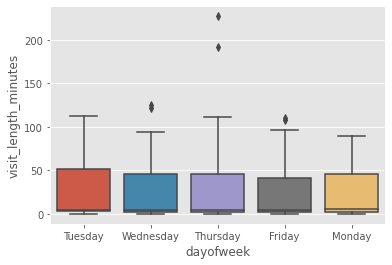

In [ ]:
axdayoftheweek = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_final)

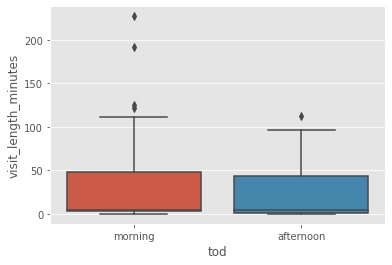

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_final)

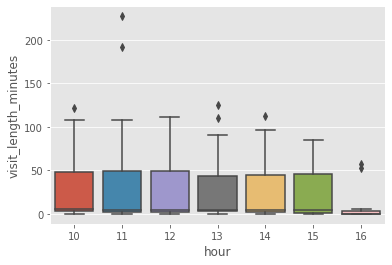

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_final)

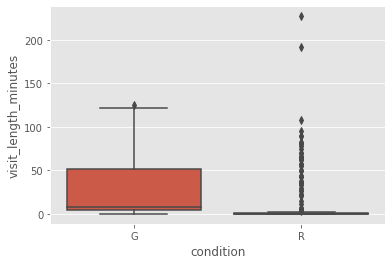

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_final)

In [ ]:
df_outliers = df_final[(np.abs(stats.zscore(df_final['visit_length_minutes'])) < 3)]
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)]
print(df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count())

Patient                 505
newfrom                 505
newto                   505
visit_length            505
start_day               505
end_day                 505
sameday                 505
dayofweek               505
tod                     505
hour                    505
condition               505
visit_length_minutes    505
dtype: int64


In [ ]:
df_nozero = df_outliers.loc[(df_outliers[['visit_length_minutes']] != 0).all(axis=1)]
df_nozero

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G1221,2021-11-30 10:13:00,2021-11-30 10:21:00,0 days 00:08:00,30,30,equal,Tuesday,morning,10,G,8.0000
1,G1223,2021-11-30 10:13:00,2021-11-30 11:50:00,0 days 01:37:00,30,30,equal,Tuesday,morning,10,G,97.0000
2,G1224,2021-11-30 10:25:00,2021-11-30 10:30:00,0 days 00:05:00,30,30,equal,Tuesday,morning,10,G,5.0000
3,G1225,2021-11-30 10:36:00,2021-11-30 10:44:00,0 days 00:08:00,30,30,equal,Tuesday,morning,10,G,8.0000
4,G1226,2021-11-30 10:39:00,2021-11-30 10:44:00,0 days 00:05:00,30,30,equal,Tuesday,morning,10,G,5.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
835,R1253,2022-01-26 16:00:00,2022-01-26 16:57:00,0 days 00:57:00,26,26,equal,Wednesday,afternoon,16,R,57.0000
840,R1304,2022-01-28 10:30:00,2022-01-28 10:31:00,0 days 00:01:00,28,28,equal,Friday,morning,10,R,1.0000
841,R1305,2022-01-28 10:30:00,2022-01-28 10:31:00,0 days 00:01:00,28,28,equal,Friday,morning,10,R,1.0000
842,R1306,2022-01-28 10:31:00,2022-01-28 11:08:00,0 days 00:37:00,28,28,equal,Friday,morning,10,R,37.0000


In [ ]:
mean = df_outliers['visit_length_minutes'].mean()
print(mean)
print(df_nozero['visit_length_minutes'].mean())

22.428400954653938
27.12121212121212


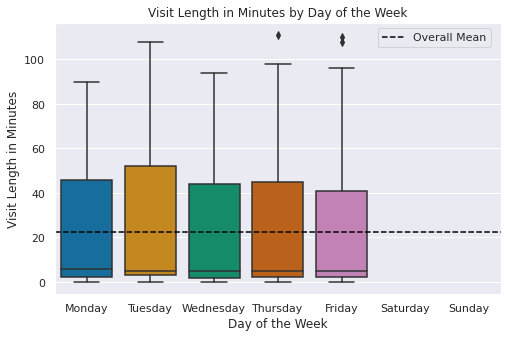

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated.png', bbox_inches='tight')

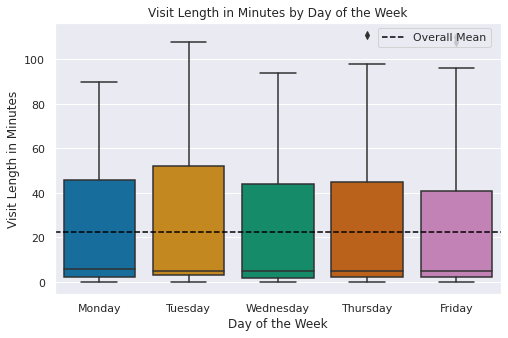

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="dayofweek", y="visit_length_minutes", data=df_outliers, order = order_list_noweekend)
svm.set_title('Visit Length in Minutes by Day of the Week')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Day of the Week')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('dayofweek_updated_noweekend.png', bbox_inches='tight')

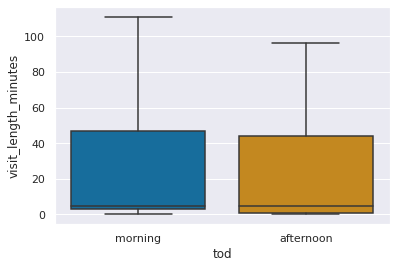

In [ ]:
axtod = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)

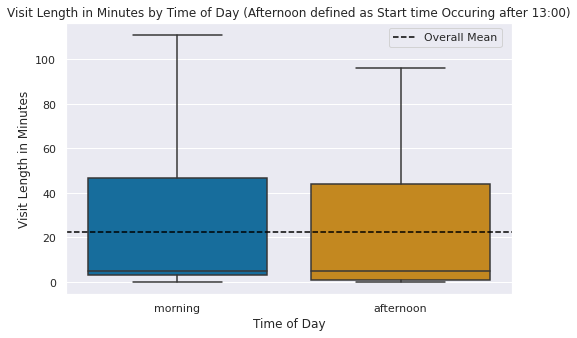

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="tod", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Time of Day (Afternoon defined as Start time Occuring after 13:00)')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('timeofday_updated.png', bbox_inches='tight')

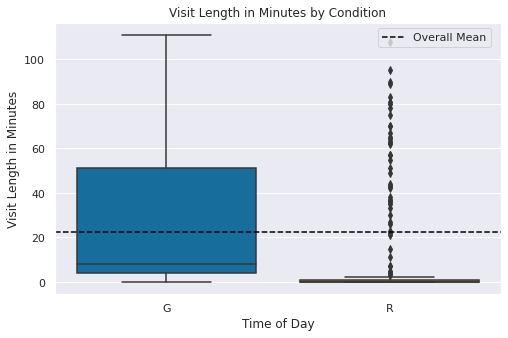

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Condition')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Time of Day')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('condition_updated.png', bbox_inches='tight')

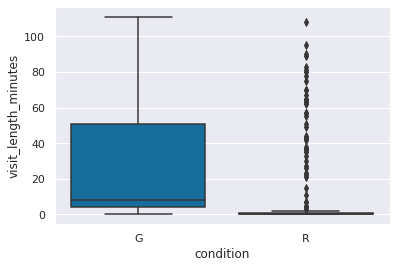

In [ ]:
axcondition = sns.boxplot(x="condition", y="visit_length_minutes", data=df_outliers)

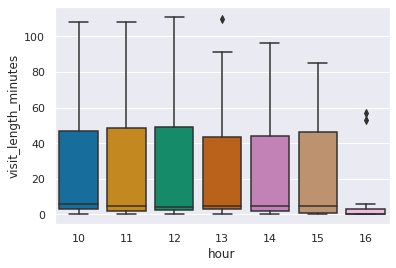

In [ ]:
axhour = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)

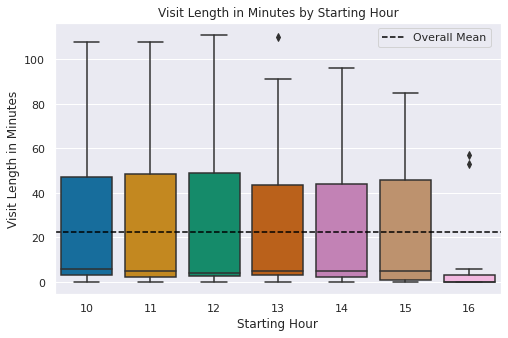

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(x="hour", y="visit_length_minutes", data=df_outliers)
svm.set_title('Visit Length in Minutes by Starting Hour')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Starting Hour')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('hour_updated.png', bbox_inches='tight')

In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
df_outliers['visit_length_minutes'].describe()

count                                   838.0000
mean                                     22.4284
std                                      27.6449
min                                       0.0000
25%                                       2.0000
50%                                       5.0000
75%                                      46.0000
max                                     111.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].describe()

count                                   843.0000
mean                                     23.2183
std                                      29.6096
min                                       0.0000
25%                                       2.0000
50%                                       5.0000
75%                                      46.0000
max                                     227.0000
Name: visit_length_minutes, dtype: float64

In [ ]:
df_final['visit_length_minutes'].median()

5.0

In [ ]:
df_outliers['visit_length'].describe()

count                          838
mean     0 days 00:22:25.704057279
std      0 days 00:27:38.691288831
min                0 days 00:00:00
25%                0 days 00:02:00
50%                0 days 00:05:00
75%                0 days 00:46:00
max                0 days 01:51:00
Name: visit_length, dtype: object

In [ ]:
df_final['visit_length'].describe()

count                          843
mean     0 days 00:23:13.096085409
std      0 days 00:29:36.574213848
min                0 days 00:00:00
25%                0 days 00:02:00
50%                0 days 00:05:00
75%                0 days 00:46:00
max                0 days 03:47:00
Name: visit_length, dtype: object

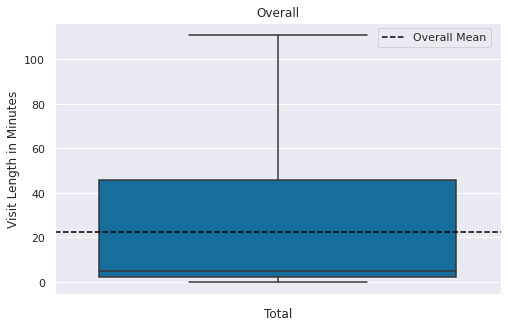

In [ ]:
sns.set_style('whitegrid')
sns.set_theme(palette="colorblind")
f,ax = plt.subplots(figsize=(8,5))
svm = sns.boxplot(y="visit_length_minutes", data=df_outliers)
svm.set_title('Overall')
svm.set_ylabel('Visit Length in Minutes')
svm.set_xlabel('Total')
svm.axhline(mean, linestyle = '--', color = 'black', label = 'Overall Mean')
svm.legend(bbox_to_anchor = (0.85, 1), loc = 'upper center')
figure1 = svm.get_figure()
figure1.savefig('tested.png', bbox_inches='tight')

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
189
Eleven
207
Twelve
95
One
79
Two
167
Three
87
Four
14


In [ ]:
print('Monday Outlier')
mondayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Monday'].count()
print(mondayoutlier)

print('Tuesday Outlier')
tuesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Tuesday'].count()
print(tuesdayoutlier)

print('Wednesday Outlier')
wednesdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Wednesday'].count()
print(wednesdayoutlier)

print('Thursday Outlier')
thursdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Thursday'].count()
print(thursdayoutlier)

print('Friday Outlier')
fridayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Friday'].count()
print(fridayoutlier)

print('Saturday Outlier')
saturdayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Saturday'].count()
print(saturdayoutlier)

print('Sunday Outlier')
sundayoutlier = df_outliers['dayofweek'][df_outliers['dayofweek']=='Sunday'].count()
print(sundayoutlier)

Monday Outlier
112
Tuesday Outlier
201
Wednesday Outlier
192
Thursday Outlier
178
Friday Outlier
155
Saturday Outlier
0
Sunday Outlier
0


In [ ]:
dayoftheweekmean = df_outliers.groupby('dayofweek')['visit_length_minutes'].mean(numeric_only=False)
dayoftheweekmean = dayoftheweekmean.reindex(index=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

In [ ]:
dayoftheweekmean

dayofweek
Monday                                       22.5179
Tuesday                                      23.8458
Wednesday                                    21.6927
Thursday                                     22.9157
Friday                                       20.8774
Saturday                                         NaN
Sunday                                           NaN
Name: visit_length_minutes, dtype: float64

In [ ]:
print('G')
glaucomacount = df_outliers['condition'][df_outliers['condition']=='G'].count()
print(glaucomacount)

print('R')
rcount = df_outliers['condition'][df_outliers['condition']=='R'].count()
print(rcount)

G
630
R
208


In [ ]:
conditionmean = df_outliers.groupby('condition')['visit_length_minutes'].mean(numeric_only=False)
conditionmean

condition
G                                    26.3603
R                                    10.5192
Name: visit_length_minutes, dtype: float64

In [ ]:
print('morning')
morningcount = df_outliers['tod'][df_outliers['tod']=='morning'].count()
print(morningcount)

print('afternoon')
afternooncount = df_outliers['tod'][df_outliers['tod']=='afternoon'].count()
print(afternooncount)

morning
570
afternoon
268


In [ ]:
todmean = df_outliers.groupby('tod')['visit_length_minutes'].mean(numeric_only=False)
todmean

tod
afternoon                                    20.9813
morning                                      23.1088
Name: visit_length_minutes, dtype: float64

In [ ]:
print('Nine')
nine_count = df_outliers['hour'][df_outliers['hour']==9].count()
print(nine_count)

print('Ten')
ten_count = df_outliers['hour'][df_outliers['hour']==10].count()
print(ten_count)

print('Eleven')
eleven_count = df_outliers['hour'][df_outliers['hour']==11].count()
print(eleven_count)

print('Twelve')
twelve_count = df_outliers['hour'][df_outliers['hour']==12].count()
print(twelve_count)

print('One')
one_count = df_outliers['hour'][df_outliers['hour']==13].count()
print(one_count)

print('Two')
two_count = df_outliers['hour'][df_outliers['hour']==14].count()
print(two_count)

print('Three')
three_count = df_outliers['hour'][df_outliers['hour']==15].count()
print(three_count)

print('Four')
four_count = df_outliers['hour'][df_outliers['hour']==16].count()
print(four_count)

Nine
0
Ten
189
Eleven
207
Twelve
95
One
79
Two
167
Three
87
Four
14


In [ ]:
hourmean = df_outliers.groupby('hour')['visit_length_minutes'].mean(numeric_only=False)
hourmean

hour
10                                    23.7513
11                                    22.7440
12                                    22.0105
13                                    23.8481
14                                    21.7844
15                                    21.4253
16                                     8.6429
Name: visit_length_minutes, dtype: float64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] < 10).all(axis=1)].count()

Patient                 505
newfrom                 505
newto                   505
visit_length            505
start_day               505
end_day                 505
sameday                 505
dayofweek               505
tod                     505
hour                    505
condition               505
visit_length_minutes    505
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length_minutes']] == 0).all(axis=1)].count()

Patient                 145
newfrom                 145
newto                   145
visit_length            145
start_day               145
end_day                 145
sameday                 145
dayofweek               145
tod                     145
hour                    145
condition               145
visit_length_minutes    145
dtype: int64

In [ ]:
df_outliers.loc[(df_outliers[['visit_length']]).all(axis=1)].count()

Patient                 693
newfrom                 693
newto                   693
visit_length            693
start_day               693
end_day                 693
sameday                 693
dayofweek               693
tod                     693
hour                    693
condition               693
visit_length_minutes    693
dtype: int64

In [ ]:
df_outliers.nsmallest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
76,G1304,2021-11-30 11:15:00,2021-11-30 11:15:00,0 days,30,30,equal,Tuesday,morning,11,G,0.0000
100,G1330,2021-12-03 16:13:00,2021-12-03 16:13:00,0 days,3,3,equal,Friday,afternoon,16,G,0.0000
131,G1362,2021-12-07 11:13:00,2021-12-07 11:13:00,0 days,7,7,equal,Tuesday,morning,11,G,0.0000
216,G1451,2021-12-21 14:46:00,2021-12-21 14:46:00,0 days,21,21,equal,Tuesday,afternoon,14,G,0.0000
636,R0871,2021-11-30 12:12:00,2021-11-30 12:12:00,0 days,30,30,equal,Tuesday,morning,12,R,0.0000


In [ ]:
df_outliers.nsmallest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
76,G1304,2021-11-30 11:15:00,2021-11-30 11:15:00,0 days,30,30,equal,Tuesday,morning,11,G,0.0000
100,G1330,2021-12-03 16:13:00,2021-12-03 16:13:00,0 days,3,3,equal,Friday,afternoon,16,G,0.0000
131,G1362,2021-12-07 11:13:00,2021-12-07 11:13:00,0 days,7,7,equal,Tuesday,morning,11,G,0.0000
216,G1451,2021-12-21 14:46:00,2021-12-21 14:46:00,0 days,21,21,equal,Tuesday,afternoon,14,G,0.0000
636,R0871,2021-11-30 12:12:00,2021-11-30 12:12:00,0 days,30,30,equal,Tuesday,morning,12,R,0.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length_minutes')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
169,G1402,2021-12-09 12:03:00,2021-12-09 13:54:00,0 days 01:51:00,9,9,equal,Thursday,morning,12,G,111.0000
424,G1675,2022-01-14 13:55:00,2022-01-14 15:45:00,0 days 01:50:00,14,14,equal,Friday,morning,13,G,110.0000
562,G1818,2022-01-25 11:08:00,2022-01-25 12:56:00,0 days 01:48:00,25,25,equal,Tuesday,morning,11,G,108.0000
747,R1077,2022-01-07 10:55:00,2022-01-07 12:43:00,0 days 01:48:00,7,7,equal,Friday,morning,10,R,108.0000
340,G1579,2022-01-06 11:41:00,2022-01-06 13:19:00,0 days 01:38:00,6,6,equal,Thursday,morning,11,G,98.0000


In [ ]:
df_outliers.nlargest(5, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
169,G1402,2021-12-09 12:03:00,2021-12-09 13:54:00,0 days 01:51:00,9,9,equal,Thursday,morning,12,G,111.0000
424,G1675,2022-01-14 13:55:00,2022-01-14 15:45:00,0 days 01:50:00,14,14,equal,Friday,morning,13,G,110.0000
562,G1818,2022-01-25 11:08:00,2022-01-25 12:56:00,0 days 01:48:00,25,25,equal,Tuesday,morning,11,G,108.0000
747,R1077,2022-01-07 10:55:00,2022-01-07 12:43:00,0 days 01:48:00,7,7,equal,Friday,morning,10,R,108.0000
340,G1579,2022-01-06 11:41:00,2022-01-06 13:19:00,0 days 01:38:00,6,6,equal,Thursday,morning,11,G,98.0000


In [ ]:
df_final.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
839,R1303,2022-01-27 11:07:00,2022-01-27 14:54:00,0 days 03:47:00,27,27,equal,Thursday,morning,11,R,227.0000
837,R1300,2022-01-27 11:42:00,2022-01-27 14:54:00,0 days 03:12:00,27,27,equal,Thursday,morning,11,R,192.0000
81,G1310,2021-12-01 13:51:00,2021-12-01 15:56:00,0 days 02:05:00,1,1,equal,Wednesday,morning,13,G,125.0000
149,G1382,2021-12-08 10:45:00,2021-12-08 12:47:00,0 days 02:02:00,8,8,equal,Wednesday,morning,10,G,122.0000
214,G1449,2021-12-21 14:16:00,2021-12-21 16:08:00,0 days 01:52:00,21,21,equal,Tuesday,afternoon,14,G,112.0000
169,G1402,2021-12-09 12:03:00,2021-12-09 13:54:00,0 days 01:51:00,9,9,equal,Thursday,morning,12,G,111.0000
424,G1675,2022-01-14 13:55:00,2022-01-14 15:45:00,0 days 01:50:00,14,14,equal,Friday,morning,13,G,110.0000
562,G1818,2022-01-25 11:08:00,2022-01-25 12:56:00,0 days 01:48:00,25,25,equal,Tuesday,morning,11,G,108.0000
747,R1077,2022-01-07 10:55:00,2022-01-07 12:43:00,0 days 01:48:00,7,7,equal,Friday,morning,10,R,108.0000
340,G1579,2022-01-06 11:41:00,2022-01-06 13:19:00,0 days 01:38:00,6,6,equal,Thursday,morning,11,G,98.0000


In [ ]:
df_outliers.nlargest(20, 'visit_length')

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
169,G1402,2021-12-09 12:03:00,2021-12-09 13:54:00,0 days 01:51:00,9,9,equal,Thursday,morning,12,G,111.0000
424,G1675,2022-01-14 13:55:00,2022-01-14 15:45:00,0 days 01:50:00,14,14,equal,Friday,morning,13,G,110.0000
562,G1818,2022-01-25 11:08:00,2022-01-25 12:56:00,0 days 01:48:00,25,25,equal,Tuesday,morning,11,G,108.0000
747,R1077,2022-01-07 10:55:00,2022-01-07 12:43:00,0 days 01:48:00,7,7,equal,Friday,morning,10,R,108.0000
340,G1579,2022-01-06 11:41:00,2022-01-06 13:19:00,0 days 01:38:00,6,6,equal,Thursday,morning,11,G,98.0000
1,G1223,2021-11-30 10:13:00,2021-11-30 11:50:00,0 days 01:37:00,30,30,equal,Tuesday,morning,10,G,97.0000
98,G1328,2021-12-03 14:50:00,2021-12-03 16:26:00,0 days 01:36:00,3,3,equal,Friday,afternoon,14,G,96.0000
696,R0971,2021-12-09 14:05:00,2021-12-09 15:40:00,0 days 01:35:00,9,9,equal,Thursday,afternoon,14,R,95.0000
85,G1315,2021-12-01 14:37:00,2021-12-01 16:11:00,0 days 01:34:00,1,1,equal,Wednesday,afternoon,14,G,94.0000
244,G1481,2021-12-24 11:04:00,2021-12-24 12:37:00,0 days 01:33:00,24,24,equal,Friday,morning,11,G,93.0000


In [ ]:
df_outliers

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
0,G1221,2021-11-30 10:13:00,2021-11-30 10:21:00,0 days 00:08:00,30,30,equal,Tuesday,morning,10,G,8.0000
1,G1223,2021-11-30 10:13:00,2021-11-30 11:50:00,0 days 01:37:00,30,30,equal,Tuesday,morning,10,G,97.0000
2,G1224,2021-11-30 10:25:00,2021-11-30 10:30:00,0 days 00:05:00,30,30,equal,Tuesday,morning,10,G,5.0000
3,G1225,2021-11-30 10:36:00,2021-11-30 10:44:00,0 days 00:08:00,30,30,equal,Tuesday,morning,10,G,8.0000
4,G1226,2021-11-30 10:39:00,2021-11-30 10:44:00,0 days 00:05:00,30,30,equal,Tuesday,morning,10,G,5.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
840,R1304,2022-01-28 10:30:00,2022-01-28 10:31:00,0 days 00:01:00,28,28,equal,Friday,morning,10,R,1.0000
841,R1305,2022-01-28 10:30:00,2022-01-28 10:31:00,0 days 00:01:00,28,28,equal,Friday,morning,10,R,1.0000
842,R1306,2022-01-28 10:31:00,2022-01-28 11:08:00,0 days 00:37:00,28,28,equal,Friday,morning,10,R,37.0000
843,R2000,2021-12-20 10:53:00,2021-12-20 11:08:00,0 days 00:15:00,20,20,equal,Monday,morning,10,R,15.0000


In [ ]:
df_outliers.loc[df_outliers['Patient'] == 'G1846']

,Patient,newfrom,newto,visit_length,start_day,end_day,sameday,dayofweek,tod,hour,condition,visit_length_minutes
588,G1846,2022-01-26 16:09:00,2022-01-26 16:15:00,0 days 00:06:00,26,26,equal,Wednesday,afternoon,16,G,6.0000


## CSV Creation

This creates a csv of the dataframe so that it can potentially be used in subsequent analysis.

In [ ]:
df_outliers['clinic_location'] = 'AF'
AFdf = df_outliers[['Patient', 'newfrom', 'newto', 'visit_length', 'dayofweek', 'tod', 'hour', 'condition', 'visit_length_minutes', 'clinic_location']].copy()
AFdf.to_csv('AFdf.csv', index=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
